# Milvus: Search at Scale

## Goal of this Notebook: 

### 1️⃣ Check the state of our Collection
We will see how we can see the state of our Milvus collection and see if it's ready to be used
### 2️⃣ Showcase the power of Filtering 
We will see the power of Filtering with Metadata, allowing us to reduce the search space.
### 3️⃣ Use Cohere Embeddings w/ Milvus for Semantic Search 
Run Semantic Search using Cohere Embeddings and the integration with Milvus. 
### 4️⃣ RAG at Scale with 35M vectors.
Perform RAG with 35M vectors. 

### 🔍 Summary 
By the end of this notebook, you'll have a better idea of how to do Search at Scale with Milvus. 

---
## Milvus
Milvus is an open-source vector database that powers AI applications with vector embeddings and similarity search.

In this notebook, we use Zilliz Cloud, the hosted version of Milvus!

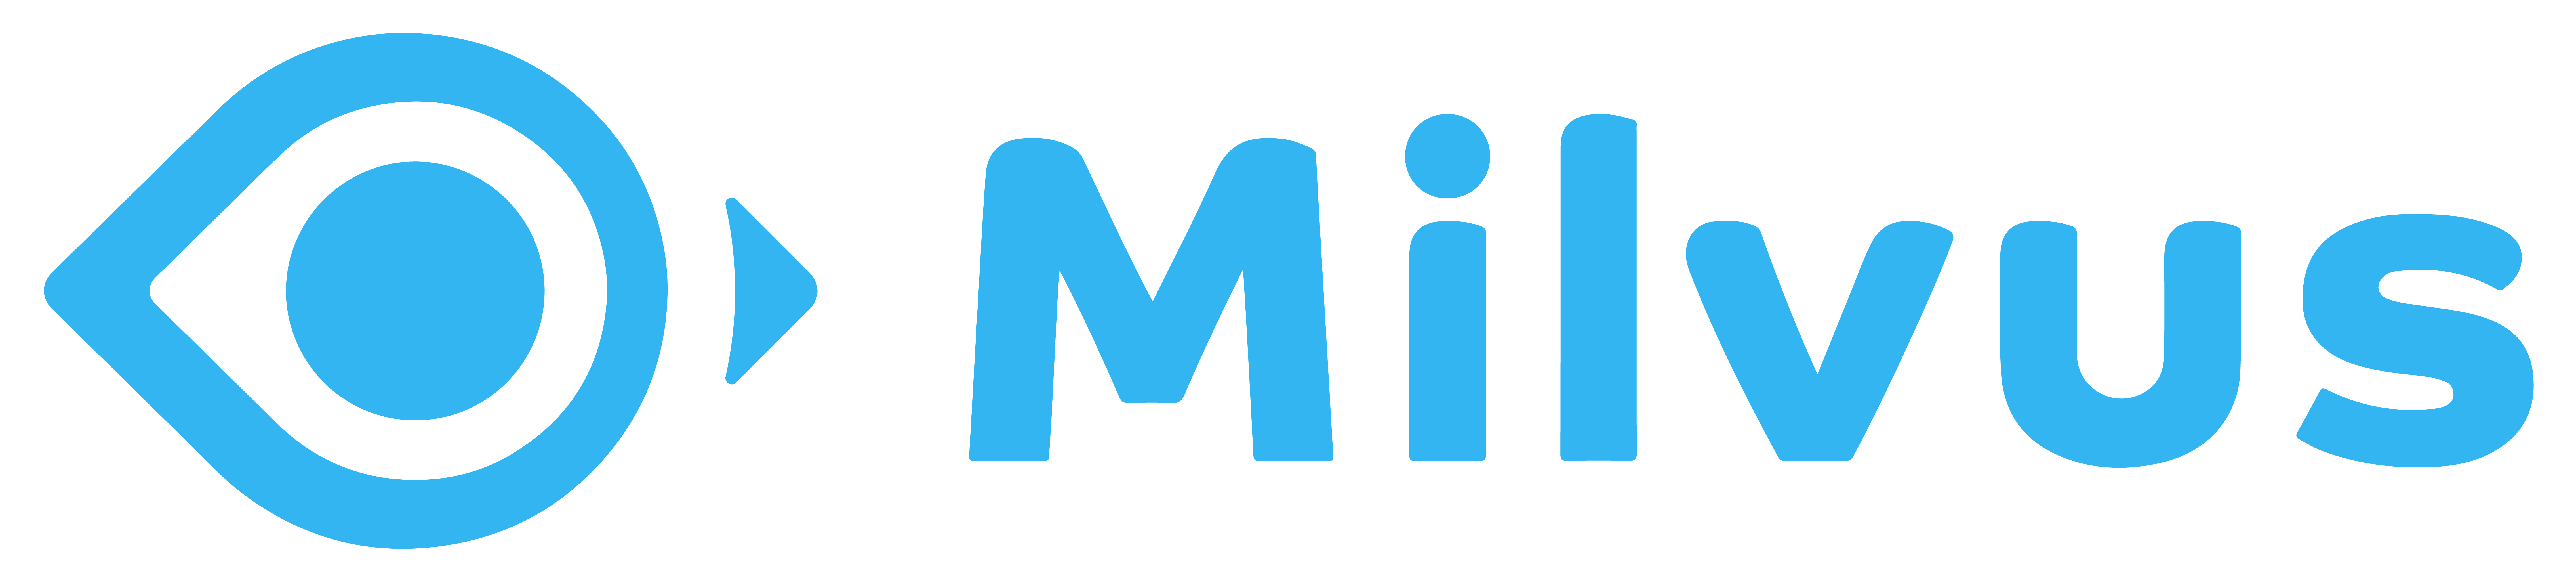

## Cohere Embeddings 

* It's using the "embed-multilingual-v3.0" model, which supports multiple languages.

* The embeddings are being stored in a Milvus vector database, enabling fast similarity searches across millions of vectors.

* This combination of Cohere Embeddings and Milvus enables efficient, scalable, and semantically-rich search capabilities across a vast amount of Wikipedia data.


## Set up dependencies and env variables

In [ ]:
! pip install -U 'pymilvus[model]' ollama openai numpy

In [ ]:
from pprint import pprint
from dotenv import load_dotenv
import os 

load_dotenv()

ZILLIZ_URI = os.getenv('URI')
ZILLIZ_TOKEN = os.getenv('TOKEN')
COHERE_API_KEY = os.getenv('COHERE_API_KEY')

# Milvus, but not Semantic Search 💅

* Milvus, while being very useful for Semantic Search isn't only about that! We can also search data using Filtering for example. 
* Milvus supports prefix, infix, suffix and wildcard searches

1. **Prefix** example, matches any string starting with “The”.

`expression='title like "The%"'`

2. **Infix** example, matches any string with the word “the” anywhere in the sentence.

`expression='title like "%the%"'`

3. **Postfix** example, matches any string ending with “Rye”.

`expression='title like "%Rye"'`

4. Single character **wildcard** example, matches any one single character at a specific position.

`expression='title like "Flip_ed"'`


In [ ]:
from pymilvus import MilvusClient

milvus_client = MilvusClient(uri=ZILLIZ_URI, token=ZILLIZ_TOKEN)

In [ ]:
milvus_client.list_collections()

In [ ]:
collection_name = "cohere_embeddings"

### Get some stats about the collection

In [ ]:
milvus_client.get_collection_stats(collection_name)

In [ ]:
milvus_client.describe_index(collection_name=collection_name, index_name="emb")

## Check if the collection is Loaded

* Before performing operations on a collection, we need to ensure it's loaded into memory. 
* Loading a collection makes it available for quick access and efficient querying.
* We'll check the load state to confirm if the collection is ready for operations.

In [ ]:
milvus_client.get_load_state(collection_name=collection_name)

In [ ]:
milvus_client.load_collection(collection_name=collection_name)

In [ ]:
milvus_client.get_load_state(collection_name=collection_name)

In [ ]:
pprint(milvus_client.describe_collection(collection_name=collection_name))

## Filtering 🪓
 
Metadata Filtering allows us to narrow down search results based on specific attributes or metadata associated with our data points. This is particularly useful for:
 
1. Refining search results: We can filter out irrelevant data and focus on specific subsets of our collection.
2. Improving search efficiency: By reducing the number of candidates to search through, we can speed up query times.
3. Enhancing user experience: Users can combine semantic search with precise filtering criteria for more accurate results.
4. Data management: It helps in organizing and categorizing large datasets for easier navigation and analysis.

In [ ]:
FILTER_TITLE = "British Arab Commercial Bank"

res = milvus_client.query(
    collection_name=collection_name,
    filter=f'title like "{FILTER_TITLE}"',
    output_fields=["title", "text"]
)
for elt in res: 
    pprint(elt)

In [ ]:
res = milvus_client.query(
    collection_name=collection_name,
    filter='text like "%Calectasia%"',
    output_fields=["title", "text"],
    limit=5,
)
for elt in res: 
    pprint(elt)

In [ ]:
res = milvus_client.query(
    collection_name=collection_name,
    filter='title not in ["British Arab Commercial Bank", "Calectasia"]',
    output_fields=["title", "text"],
    limit=10,
)
for elt in res: 
    pprint(elt)

## Cohere 🤝 Milvus: Unleashing Powerful Semantic Search

Cohere and Milvus form a powerful combination for semantic search:

- Cohere: Provides state-of-the-art LLM models and embeddings
- Milvus: Offers scalable vector similarity search and management

Together, we can have:
1. High-quality text embeddings generation
2. Efficient storage and indexing of large-scale vector data
3. Fast and accurate semantic similarity search
4. Multilingual support for global applications
5. Scalability for handling billions of vectors


## Use Milvus direct integration with Cohere

In [ ]:
from pymilvus.model.dense import CohereEmbeddingFunction

cohere_ef = CohereEmbeddingFunction(
    model_name="embed-multilingual-v3.0",
    input_type="search_query",
    embedding_types=["float"]
)

## Encode Documents 

Documents are a list of string, it's very useful when you are actually creating embeddings at scale

In [ ]:
docs = [
    "Artificial intelligence was founded as an academic discipline in 1956.",
    "Open Source Summit is a conference umbrella",
    "Linux is an operating system kernel first released on September 17, 1991, by Linus Torvalds.",
]

docs_embeddings = cohere_ef.encode_documents(docs)

print("Embeddings:", docs_embeddings[0][:10])
print("Dim:", cohere_ef.dim, docs_embeddings[0].shape)


## Encode Queries

Queries are a string, this is usually what you'd use when a user is asking a question for example

In [ ]:
query = 'Who created the OS Linux?'
embedded_query = cohere_ef.encode_queries([query])

response = embedded_query
print(response[0][:10])

## Semantic Search 

* In this section, we'll perform semantic search using the embeddings we created earlier.
* Semantic search allows us to find relevant documents based on the meaning of a query, rather than just keyword matching. 

* We'll use our encoded query to search for similar documents in our Milvus collection.


In [ ]:
res = milvus_client.search(data=response, collection_name=collection_name, output_fields=["text"], limit=3)
for elt in res:
    pprint(elt)

# What if we have more than 1 query?

To simulate a real-world scenario with multiple queries, we'll generate 1000 random vectors.
We'll use these to showcase the performance of Milvus for batch processing, focusing on two key metrics:

1. P99 (99th percentile) search time: This represents the worst-case scenario, where 99% of queries are faster than this time.
2. Average search time: This gives us the typical performance of our system.

By measuring these metrics, we can evaluate how Milvus handles a large number of search queries, providing insights into its scalability and efficiency.


In [ ]:
import numpy as np

# Generate 1000 random vectors of size 1024
random_vectors = np.random.rand(1000, 1024).tolist()

for vector in random_vectors:
    milvus_client.search(data=[vector], collection_name=collection_name, output_fields=["text"], limit=3)

# Make the results look pretty ✨

In [ ]:
import json
retrieved_lines_with_distances = [
    (result["entity"]["text"], result["distance"]) for result in res[0]
]
print(json.dumps(retrieved_lines_with_distances, indent=4))

## Use LLM to get a RAG response

In this section, we'll use an LLM to generate a response based on the retrieved context.
This is a key component of the Retrieval-Augmented Generation (RAG) process:

1. We've already performed the Retrieval step by finding relevant documents using semantic search.
2. Now, we'll use these retrieved documents as context for the LLM.
3. The LLM will generate a response that's informed by this context, combining the retrieved information
    with its own knowledge to provide a more accurate and relevant answer.

This approach allows us to leverage the power of LLMs while grounding their responses in specific, up-to-date information from our document collection.

In [ ]:
context = "\n".join(
    [line_with_distance[0] for line_with_distance in retrieved_lines_with_distances]
)

In [ ]:
question = "Who created the OS Linux?"

In [ ]:
SYSTEM_PROMPT = """
Human: You are an AI assistant. You are able to find answers to the questions from the contextual passage snippets provided.
"""

USER_PROMPT = f"""
    Use the following pieces of information enclosed in <context> tags to provide an answer to the question enclosed in <question> tags.
    <context>
    {context}
    </context>
    <question>
    {question}
    </question>
"""

In [ ]:
from openai import OpenAI

client = OpenAI(
    base_url = 'http://localhost:11434/v1',
    api_key='ollama', # required, but unused
)

response = client.chat.completions.create(
    model="llama3.1",
    messages=[
        {"role": "system", "content": SYSTEM_PROMPT},
        {"role": "user", "content": USER_PROMPT},
    ],
)
print(response.choices[0].message.content)

# Conclusion

In this notebook, we've explored a powerful approach to large-scale information retrieval and question answering. Here's what we've learned:

1. We used Milvus to efficiently store and query a large dataset of text embeddings.
2. We implemented semantic search to retrieve relevant context for our questions.
3. We used a local model Llama 3.1 to generate responses based on the retrieved context.
4. This combination of vector search and language models allows us to build a system that can answer questions based on a vast amount of information quickly and accurately.


## Release the collection

In [ ]:
milvus_client.release_collection(collection_name=collection_name)

# ⭐️ Github 
I hope you liked this demo showcasing how to run Vector Search at Scale with Milvus and Cohere. If you liked it and our project, please give us a **star on Github**! ⭐


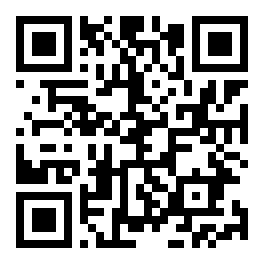

# 🤝 Add me on LinkedIn

If you have some questions related to Milvus, GenAI, etc, I am [Stephen Batifol](https://www.linkedin.com/in/stephen-batifol/), you can add me on LinkedIn and I'll gladly help you.

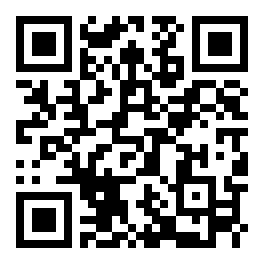